In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import warnings
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from itertools import repeat
from time import perf_counter
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from matplotlib import pyplot as plt
from lightgbm import plot_importance
from lightgbm import plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
pd.set_option('display.max_columns', None)

In [ ]:
file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)
df.head(3)

,imp_id,content_id,server_time_kst_x,imp_hour,bid_price_x,click_label,user_gender,user_age_group,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,name,keyword,price,flag_used,category1,emergency_cnt,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count,m_time,content_img_url
0,9919612e44382421285c,162261579,2021-09-01 00:01:42.466000+09:00,0,55,0,F,1,16,3,0,0,0,2,Z플립 5G 256GB [그레이] 48082 (S급),"Z플립5G,제트플립,제트플립5G,갤럭시Z플립5G,Z플립5G그레이",580000.0,1.0,600,0.0,0.0,120.0,4.0,2063.0,7539.0,784.0,3424.0,755.0,392.0,677.0,0.0,5.0,236.0,1629443915,https://media.bunjang.co.kr/product/162261579_...
1,9919612e444924217d59,145430389,2021-09-01 00:01:42.466000+09:00,0,70,0,F,2,26,0,0,0,0,0,최저가60 무선청소기 기펠상위모델 국내브랜드 셀프스텐드 정품무배,"기펠청소기,무선청소기,코드제로,에어슬림",135000.0,2.0,600,0.0,3.0,5385.0,153.0,799.0,5520.0,433.0,16794.0,570.0,250.0,942.0,0.0,57.0,11.0,1629943339,https://media.bunjang.co.kr/product/145430389_...
2,97f9612e444d18489e0e,98827336,2021-09-01 00:01:40.339000+09:00,0,50,0,F,5,53,0,0,0,0,0,정품 원터치텐트 낚시텐트 자외선차단텐트 방수텐트 캠핑텐트 간편 자동텐트,"원터치텐트간편텐트,낚시텐트등산텐트,자외선차단방수텐트,자동텐트감성캠핑,캠핑용품그늘막",26000.0,2.0,700,0.0,12.0,29950.0,759.0,2120.0,3252.0,2053.0,32794.0,351.0,441.0,166.0,0.0,16.0,3.0,1627289231,https://media.bunjang.co.kr/product/98827336_1...


In [ ]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }

def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
data = reorganization(df)
data.columns

Index(['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used',
       'category1', 'emergency_cnt', 'user_age', 'user_following_cnt',
       'user_pay_count', 'user_parcel_post_count', 'user_transfer_count',
       'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt',
       'adver_favorite_count', 'adver_grade', 'adver_item_count',
       'adver_interest', 'adver_review_count', 'adver_comment_count',
       'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count',
       'adver_chat_count'],
      dtype='object')

In [ ]:
data.head(3)

,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,F,0,0,1,1.0,600,0.0,16,3,0,0,0,2,580000.0,0.0,120.0,4.0,2063.0,7539.0,784.0,3424.0,755.0,392.0,677.0,0.0,5.0,236.0
1,F,0,0,2,2.0,600,0.0,26,0,0,0,0,0,135000.0,3.0,5385.0,153.0,799.0,5520.0,433.0,16794.0,570.0,250.0,942.0,0.0,57.0,11.0
2,F,0,0,5,2.0,700,0.0,53,0,0,0,0,0,26000.0,12.0,29950.0,759.0,2120.0,3252.0,2053.0,32794.0,351.0,441.0,166.0,0.0,16.0,3.0


In [ ]:
def preprocessing(df):
    # 데이터 유형별 분류하기
    modified_df = pd.DataFrame()

    for i, c in enumerate(df.columns): 
        if (c in cols['obj']) | (c in cols['cat']): 
          if 'click' in c:    # click_label 컬럼 = y 변수로 사용 (그대로 두기)
                modified_df = pd.concat([modified_df, df[c]], axis=1)
          else:
            dummied_data = LabelEncoder().fit_transform(df[[c]])
            dummied_data = pd.DataFrame(dummied_data, columns = [c])
            modified_df = pd.concat([modified_df, dummied_data], axis=1)

        else:
            scaled_num_data = RobustScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)

    print('---- Data info ----')
    print(f'Modified DF columns: {modified_df.columns.to_list()}')
    print(f'# of Modified DF columns: {modified_df.shape[1]}')
    print(f'DataFrame has no null?', end = ' ')
    if df.isnull().sum().count() == df.shape[1]:
      print('Yes')
    else:
      print('No')
    return modified_df

In [ ]:
df = preprocessing(data)
df.head(3)

---- Data info ----
Modified DF columns: ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']
# of Modified DF columns: 27
DataFrame has no null? Yes


,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,0,0,0,0,0,10,0,-0.904762,0.4,0.0,0.0,0.0,2.0,0.442373,0.0,-0.138204,-0.190476,0.541252,0.731446,0.742301,-0.030500,0.695833,0.246594,1.209776,0.0,0.714286,17.769231
1,0,0,0,1,1,10,0,-0.428571,-0.2,0.0,0.0,0.0,0.0,-0.311864,3.0,0.607335,1.228571,-0.086978,0.442728,0.173420,0.339880,0.438889,0.053134,1.749491,0.0,8.142857,0.461538
2,0,0,0,4,1,11,0,0.857143,-0.2,0.0,0.0,0.0,0.0,-0.496610,12.0,4.085811,7.000000,0.569583,0.118404,2.799028,0.783118,0.134722,0.313351,0.169043,0.0,2.285714,-0.153846


In [ ]:
X = df[df.columns.difference(['click_label'])]
y = df['click_label']

print(f"X features' name (10): {X.columns.to_list()[:10]}")
print(f"y feature's name: {y.name}")
print()

## create train and test datasets (7:3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기

print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
print()
print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("data's shape (x -> y & train -> test): ", (X_train.shape, y_train.shape, X_test.shape, y_train.shape))
print()

# ## create train and validation datasets (8:2 ratio)
# x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)

# print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
# print()
# print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
# print("data's shape (x -> y & train -> test): ", (x_train.shape, y_train.shape, x_val.shape, y_train.shape))
# print()

X features' name (10): ['ad_interest', 'ad_pfavcnt', 'adver_chat_count', 'adver_comment_count', 'adver_favorite_count', 'adver_grade', 'adver_interest', 'adver_item_count', 'adver_parcel_post_count', 'adver_pay_count']
y feature's name: click_label

# of train_data's rows: 589724 
# of test_data's rows: 252739

train:test ratio = 0.7:0.3
data's shape (x -> y & train -> test):  ((1144850, 26), (1144850,), (252739, 26), (1144850,))



In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200)
lgb_model = lgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set = [(X_test, y_test)])
lgb_model

[1]	valid_0's binary_logloss: 0.668085	valid_0's binary_logloss: 0.668085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.649465	valid_0's binary_logloss: 0.649465
[3]	valid_0's binary_logloss: 0.628328	valid_0's binary_logloss: 0.628328
[4]	valid_0's binary_logloss: 0.612354	valid_0's binary_logloss: 0.612354
[5]	valid_0's binary_logloss: 0.595227	valid_0's binary_logloss: 0.595227
[6]	valid_0's binary_logloss: 0.576149	valid_0's binary_logloss: 0.576149
[7]	valid_0's binary_logloss: 0.564478	valid_0's binary_logloss: 0.564478
[8]	valid_0's binary_logloss: 0.551357	valid_0's binary_logloss: 0.551357
[9]	valid_0's binary_logloss: 0.537795	valid_0's binary_logloss: 0.537795
[10]	valid_0's binary_logloss: 0.5291	valid_0's binary_logloss: 0.5291
[11]	valid_0's binary_logloss: 0.51745	valid_0's binary_logloss: 0.51745
[12]	valid_0's binary_logloss: 0.506523	valid_0's binary_logloss: 0.506523
[13]	valid_0's binary_logloss: 0.495007	valid_0's bin

LGBMClassifier(n_estimators=200, random_state=2022)

In [ ]:
# 모델 성능을 출력해보자.
print('train score : {:.3f}'.format(lgb_model.score(X_train, y_train)))
print('test score : {:.3f}'.format(lgb_model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, lgb_model.predict(X_test)))
print(confusion_matrix(y_test, lgb_model.predict(X_test)))

train score : 0.954
test score : 0.965
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    245325
           1       0.15      0.04      0.06      7414

    accuracy                           0.97    252739
   macro avg       0.56      0.52      0.52    252739
weighted avg       0.95      0.97      0.96    252739

[[243631   1694]
 [  7110    304]]


In [ ]:
lgb_model.predict_proba(X_test)

array([[0.89313959, 0.10686041],
       [0.85382804, 0.14617196],
       [0.77349662, 0.22650338],
       ...,
       [0.89941742, 0.10058258],
       [0.94377935, 0.05622065],
       [0.92647858, 0.07352142]])

In [ ]:
# GridSearchCV(모델, param_grid, cv, scoring, n_jobs, verbose)
param_grid = {
    'max_depth' :[50, 100, 150], 
    'learning_rate' :[0.001, 0.01, 0.1],
}

# 전처리를 거친 x_train으로 grid search cross validation 수행
gs = GridSearchCV(lgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring = 'f1')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(n_estimators=200, random_state=2022),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [50, 100, 150]},
             scoring='f1', verbose=1)

In [ ]:
model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200, learning_rate=0.001, max_depth=50)
model = model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set = [(X_test, y_test)])

[1]	valid_0's binary_logloss: 0.692887	valid_0's binary_logloss: 0.692887
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.692627	valid_0's binary_logloss: 0.692627
[3]	valid_0's binary_logloss: 0.692368	valid_0's binary_logloss: 0.692368
[4]	valid_0's binary_logloss: 0.692109	valid_0's binary_logloss: 0.692109
[5]	valid_0's binary_logloss: 0.69185	valid_0's binary_logloss: 0.69185
[6]	valid_0's binary_logloss: 0.691592	valid_0's binary_logloss: 0.691592
[7]	valid_0's binary_logloss: 0.691335	valid_0's binary_logloss: 0.691335
[8]	valid_0's binary_logloss: 0.691078	valid_0's binary_logloss: 0.691078
[9]	valid_0's binary_logloss: 0.690821	valid_0's binary_logloss: 0.690821
[10]	valid_0's binary_logloss: 0.690572	valid_0's binary_logloss: 0.690572
[11]	valid_0's binary_logloss: 0.690323	valid_0's binary_logloss: 0.690323
[12]	valid_0's binary_logloss: 0.690075	valid_0's binary_logloss: 0.690075
[13]	valid_0's binary_logloss: 0.689827	valid_0's

In [ ]:
# 가장 좋은 성능을 보인 파라미터 조합의 estimator을 model에 저장
model = gs.best_estimator_

# dataset 데이터를 예측 및 성능 평가
data_pred = model.predict(X_test)

In [ ]:
print(f'optimized parameters: {model}')

optimized parameters: LGBMClassifier(learning_rate=0.001, max_depth=50, n_estimators=200,
               random_state=2022)


In [ ]:
print('test score : {:.3f}'.format(model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, data_pred))
print(confusion_matrix(y_test, data_pred))

test score : 0.964
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    245325
           1       0.14      0.04      0.07      7414

    accuracy                           0.96    252739
   macro avg       0.56      0.52      0.52    252739
weighted avg       0.95      0.96      0.95    252739

[[243428   1897]
 [  7097    317]]


In [ ]:
model.predict_proba(X_test)

array([[0.87829437, 0.12170563],
       [0.82225317, 0.17774683],
       [0.79210253, 0.20789747],
       ...,
       [0.87758324, 0.12241676],
       [0.93390912, 0.06609088],
       [0.94492764, 0.05507236]])

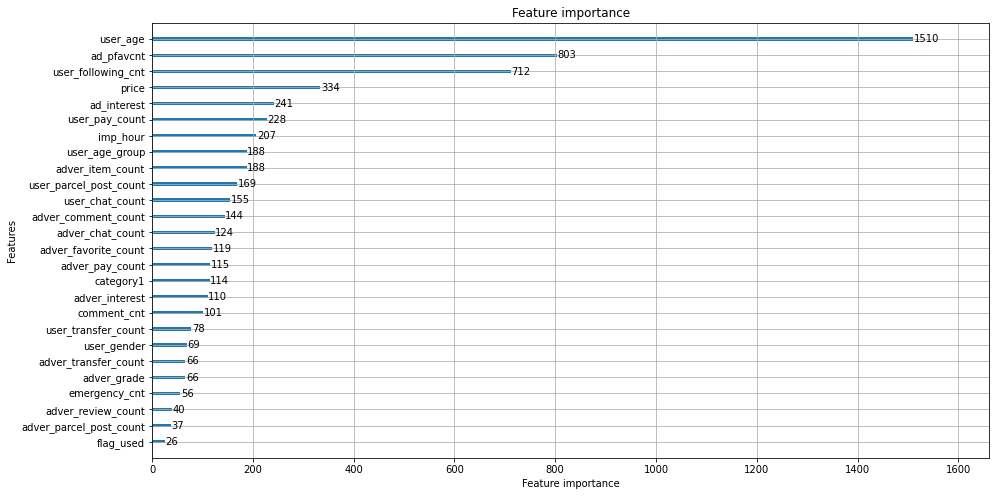

In [ ]:
# 특성 중요도를 시각화
fig, ax = plt.subplots(figsize = (15, 8))
plot_importance(model, ax=ax)
plt.show()

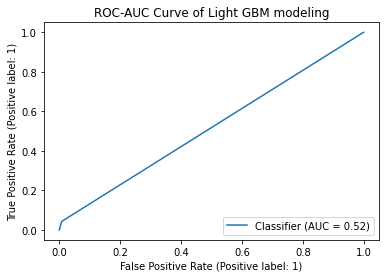

In [ ]:
RocCurveDisplay.from_predictions(y_test, data_pred)
plt.title('ROC-AUC Curve of Light GBM modeling')
plt.show()

# 훈련/검증데이터 분리

In [ ]:
file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)
df.head(3)

,imp_id,content_id,server_time_kst_x,imp_hour,bid_price_x,click_label,user_gender,user_age_group,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,name,keyword,price,flag_used,category1,emergency_cnt,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count,m_time,content_img_url
0,9919612e44382421285c,162261579,2021-09-01 00:01:42.466000+09:00,0,55,0,F,1,16,3,0,0,0,2,Z플립 5G 256GB [그레이] 48082 (S급),"Z플립5G,제트플립,제트플립5G,갤럭시Z플립5G,Z플립5G그레이",580000.0,1.0,600,0.0,0.0,120.0,4.0,2063.0,7539.0,784.0,3424.0,755.0,392.0,677.0,0.0,5.0,236.0,1629443915,https://media.bunjang.co.kr/product/162261579_...
1,9919612e444924217d59,145430389,2021-09-01 00:01:42.466000+09:00,0,70,0,F,2,26,0,0,0,0,0,최저가60 무선청소기 기펠상위모델 국내브랜드 셀프스텐드 정품무배,"기펠청소기,무선청소기,코드제로,에어슬림",135000.0,2.0,600,0.0,3.0,5385.0,153.0,799.0,5520.0,433.0,16794.0,570.0,250.0,942.0,0.0,57.0,11.0,1629943339,https://media.bunjang.co.kr/product/145430389_...
2,97f9612e444d18489e0e,98827336,2021-09-01 00:01:40.339000+09:00,0,50,0,F,5,53,0,0,0,0,0,정품 원터치텐트 낚시텐트 자외선차단텐트 방수텐트 캠핑텐트 간편 자동텐트,"원터치텐트간편텐트,낚시텐트등산텐트,자외선차단방수텐트,자동텐트감성캠핑,캠핑용품그늘막",26000.0,2.0,700,0.0,12.0,29950.0,759.0,2120.0,3252.0,2053.0,32794.0,351.0,441.0,166.0,0.0,16.0,3.0,1627289231,https://media.bunjang.co.kr/product/98827336_1...


In [ ]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }

def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
data = reorganization(df)
data.columns

Index(['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used',
       'category1', 'emergency_cnt', 'user_age', 'user_following_cnt',
       'user_pay_count', 'user_parcel_post_count', 'user_transfer_count',
       'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt',
       'adver_favorite_count', 'adver_grade', 'adver_item_count',
       'adver_interest', 'adver_review_count', 'adver_comment_count',
       'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count',
       'adver_chat_count'],
      dtype='object')

In [ ]:
data.head(3)

,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,F,0,0,1,1.0,600,0.0,16,3,0,0,0,2,580000.0,0.0,120.0,4.0,2063.0,7539.0,784.0,3424.0,755.0,392.0,677.0,0.0,5.0,236.0
1,F,0,0,2,2.0,600,0.0,26,0,0,0,0,0,135000.0,3.0,5385.0,153.0,799.0,5520.0,433.0,16794.0,570.0,250.0,942.0,0.0,57.0,11.0
2,F,0,0,5,2.0,700,0.0,53,0,0,0,0,0,26000.0,12.0,29950.0,759.0,2120.0,3252.0,2053.0,32794.0,351.0,441.0,166.0,0.0,16.0,3.0


In [ ]:
def preprocessing(df):
    # 데이터 유형별 분류하기
    modified_df = pd.DataFrame()

    for i, c in enumerate(df.columns): 
        if (c in cols['obj']) | (c in cols['cat']): 
          if 'click' in c:    # click_label 컬럼 = y 변수로 사용 (그대로 두기)
                modified_df = pd.concat([modified_df, df[c]], axis=1)
          else:
            dummied_data = LabelEncoder().fit_transform(df[[c]])
            dummied_data = pd.DataFrame(dummied_data, columns = [c])
            modified_df = pd.concat([modified_df, dummied_data], axis=1)

        else:
            scaled_num_data = RobustScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)

    print('---- Data info ----')
    print(f'Modified DF columns: {modified_df.columns.to_list()}')
    print(f'# of Modified DF columns: {modified_df.shape[1]}')
    print(f'DataFrame has no null?', end = ' ')
    if df.isnull().sum().count() == df.shape[1]:
      print('Yes')
    else:
      print('No')
    return modified_df

In [ ]:
df = preprocessing(data)
df.head(3)

---- Data info ----
Modified DF columns: ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']
# of Modified DF columns: 27
DataFrame has no null? Yes


,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,0,0,0,0,0,10,0,-0.904762,0.4,0.0,0.0,0.0,2.0,0.442373,0.0,-0.138204,-0.190476,0.541252,0.731446,0.742301,-0.030500,0.695833,0.246594,1.209776,0.0,0.714286,17.769231
1,0,0,0,1,1,10,0,-0.428571,-0.2,0.0,0.0,0.0,0.0,-0.311864,3.0,0.607335,1.228571,-0.086978,0.442728,0.173420,0.339880,0.438889,0.053134,1.749491,0.0,8.142857,0.461538
2,0,0,0,4,1,11,0,0.857143,-0.2,0.0,0.0,0.0,0.0,-0.496610,12.0,4.085811,7.000000,0.569583,0.118404,2.799028,0.783118,0.134722,0.313351,0.169043,0.0,2.285714,-0.153846


In [ ]:
df.corr()

,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
user_gender,1.000000,-0.016173,-0.038505,0.164744,0.055845,-0.148161,-0.037498,0.165594,0.070922,-0.005686,0.062445,-0.004316,-0.011435,0.059747,0.003950,-0.019473,-0.025046,-0.129160,-0.092434,0.097184,-0.018167,-0.093951,-0.086289,-0.099786,0.082972,-0.007384,-0.074811
imp_hour,-0.016173,1.000000,-0.000788,0.045370,-0.035925,0.010852,0.002569,0.040842,-0.010723,-0.001828,0.003938,-0.001196,0.001371,-0.010372,-0.025937,-0.010164,-0.014489,0.013599,0.016197,0.014780,-0.010134,0.015755,0.005253,0.032706,-0.017586,-0.005094,0.014258
click_label,-0.038505,-0.000788,1.000000,-0.015347,0.008735,0.051875,-0.003275,-0.015331,-0.011283,-0.003832,-0.010909,-0.000448,-0.002152,-0.018773,-0.006077,-0.003727,-0.001823,0.026983,0.021913,-0.007354,-0.009022,0.022110,0.002520,0.022283,-0.008236,0.012271,0.019394
user_age_group,0.164744,0.045370,-0.015347,1.000000,0.029856,-0.007028,-0.041308,0.977943,0.028908,0.013419,0.024375,0.007002,0.003886,0.023970,0.009131,-0.025288,-0.037707,-0.089792,-0.084390,0.037838,-0.014829,-0.084297,-0.070374,-0.052509,0.045536,0.020225,-0.079629
flag_used,0.055845,-0.035925,0.008735,0.029856,1.000000,-0.022692,0.141965,0.031179,0.009132,0.009841,0.005852,0.010947,0.002792,0.022953,0.077368,0.039571,0.043443,0.175332,-0.028091,-0.185565,0.126860,-0.019268,-0.051055,-0.288002,-0.063515,-0.010040,-0.248201
category1,-0.148161,0.010852,0.051875,-0.007028,-0.022692,1.000000,0.041937,-0.002307,-0.042147,-0.006505,-0.054586,-0.008905,-0.006115,-0.020585,-0.026801,-0.023837,-0.025126,0.047871,0.050711,-0.220056,-0.101258,0.050761,-0.022745,0.186111,-0.184916,0.003881,0.140098
emergency_cnt,-0.037498,0.002569,-0.003275,-0.041308,0.141965,0.041937,1.000000,-0.044771,-0.012260,0.031762,-0.004245,0.024937,0.009763,-0.060813,0.262132,0.392323,0.442813,0.044471,0.058666,-0.139349,0.124485,0.059345,0.071532,-0.055001,-0.109601,0.026730,-0.013829
user_age,0.165594,0.040842,-0.015331,0.977943,0.031179,-0.002307,-0.044771,1.000000,0.028773,0.014421,0.019975,0.006823,0.002050,0.029593,0.011198,-0.025195,-0.037654,-0.093711,-0.087135,0.038354,-0.014332,-0.087097,-0.072706,-0.052759,0.044400,0.022427,-0.080712
user_following_cnt,0.070922,-0.010723,-0.011283,0.028908,0.009132,-0.042147,-0.012260,0.028773,1.000000,0.011417,0.066863,0.014753,0.009954,0.010192,0.000047,-0.006569,-0.008395,-0.018579,-0.014496,0.021574,0.006170,-0.014741,-0.015665,-0.015575,0.021247,-0.000600,-0.015105
user_pay_count,-0.005686,-0.001828,-0.003832,0.013419,0.009841,-0.006505,0.031762,0.014421,0.011417,1.000000,0.161316,0.789113,0.120942,-0.002142,0.025676,0.014422,0.019706,0.007022,0.005936,-0.004285,0.021799,0.006248,0.000652,-0.002348,-0.004916,0.002255,-0.002524


Text(0.5, 1.0, 'X - Features Correlations')

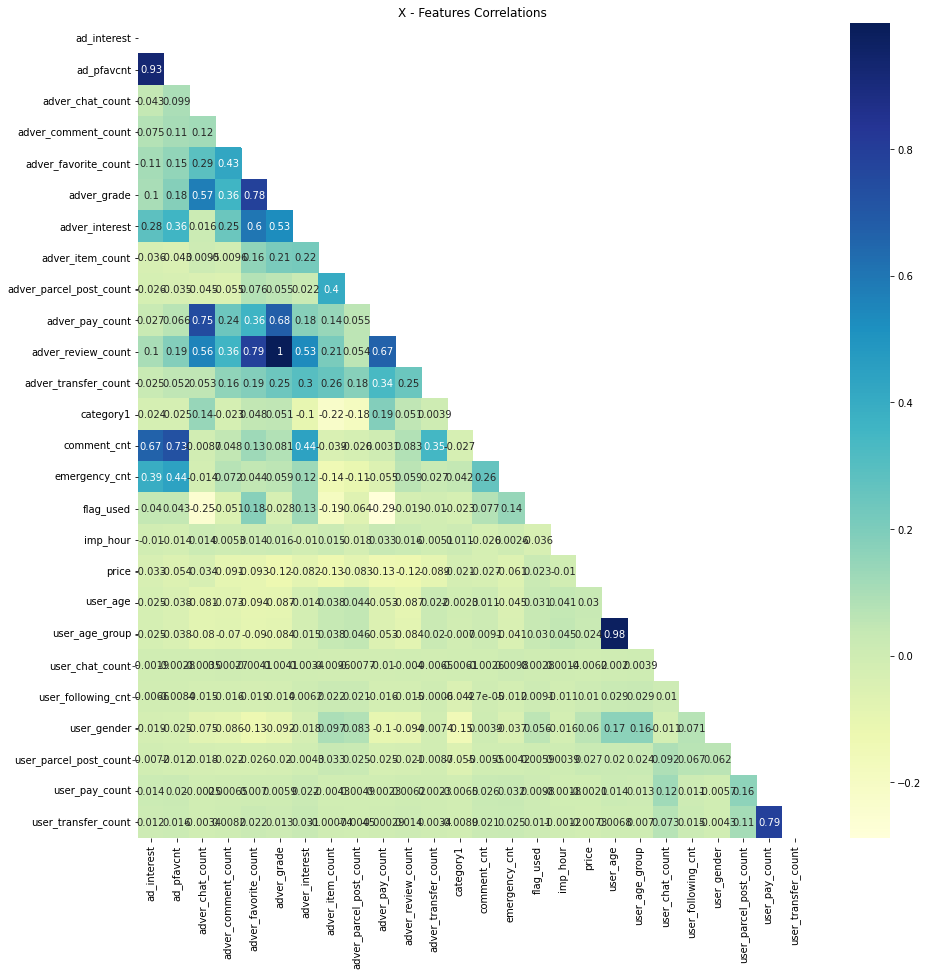

In [ ]:
import seaborn as sns
# 0으로 채운 array 생성
mask = np.zeros_like(data.corr())
# 위 쪽 삼각형 모양에 해당하는 cell만 값을 True로 지정
mask[np.triu_indices_from(mask)] = True

# 그래프 크기 설정
fig = plt.figure(figsize=(15,15))
# data 전체 칼럼의 상관계수의 heatmap plot
fig = sns.heatmap(df[df.columns.difference(['click_label'])].corr(), mask=mask, cmap="YlGnBu", annot=True)
# 그래프 제목 설정
fig.set_title('X - Features Correlations')

In [ ]:
X = df[df.columns.difference(['click_label'])]
y = df['click_label']

print(f"X features' name (10): {X.columns.to_list()[:10]}")
print(f"y feature's name: {y.name}")
print()

## create train and test datasets (7:3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기

print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
print()
print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("data's shape (x -> y & train -> test): ", (X_train.shape, y_train.shape, X_test.shape, y_train.shape))
print()

## create train and validation datasets (8:2 ratio)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)

print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
print()
print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
print("data's shape (x -> y & train -> test): ", (x_train.shape, y_train.shape, x_val.shape, y_val.shape))
print()

X features' name (10): ['ad_interest', 'ad_pfavcnt', 'adver_chat_count', 'adver_comment_count', 'adver_favorite_count', 'adver_grade', 'adver_interest', 'adver_item_count', 'adver_parcel_post_count', 'adver_pay_count']
y feature's name: click_label

# of train_data's rows: 589724 
# of test_data's rows: 252739

train:test ratio = 0.7:0.3
data's shape (x -> y & train -> test):  ((1144850, 26), (1144850,), (252739, 26), (1144850,))

# of train_data's rows: 915880 
# of validation_data's rows: 228970

train:test ratio = 0.8:0.2
data's shape (x -> y & train -> test):  ((915880, 26), (915880,), (228970, 26), (228970,))



In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200)
lgb_model = lgb_model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set = [(x_val, y_val)])
lgb_model

[1]	valid_0's binary_logloss: 0.666279	valid_0's binary_logloss: 0.666279
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.647673	valid_0's binary_logloss: 0.647673
[3]	valid_0's binary_logloss: 0.626006	valid_0's binary_logloss: 0.626006
[4]	valid_0's binary_logloss: 0.60671	valid_0's binary_logloss: 0.60671
[5]	valid_0's binary_logloss: 0.592271	valid_0's binary_logloss: 0.592271
[6]	valid_0's binary_logloss: 0.579296	valid_0's binary_logloss: 0.579296
[7]	valid_0's binary_logloss: 0.566179	valid_0's binary_logloss: 0.566179
[8]	valid_0's binary_logloss: 0.550634	valid_0's binary_logloss: 0.550634
[9]	valid_0's binary_logloss: 0.538594	valid_0's binary_logloss: 0.538594
[10]	valid_0's binary_logloss: 0.530192	valid_0's binary_logloss: 0.530192
[11]	valid_0's binary_logloss: 0.519278	valid_0's binary_logloss: 0.519278
[12]	valid_0's binary_logloss: 0.511543	valid_0's binary_logloss: 0.511543
[13]	valid_0's binary_logloss: 0.501988	valid_0's

LGBMClassifier(n_estimators=200, random_state=2022)

In [ ]:
# 모델 성능을 출력해보자.
print('train score : {:.3f}'.format(lgb_model.score(x_train, y_train)))
print('validation score : {:.3f}'.format(lgb_model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, lgb_model.predict(x_val)))
print(confusion_matrix(y_val, lgb_model.predict(x_val)))

train score : 0.954
validation score : 0.954
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96    114485
           1       0.99      0.92      0.95    114485

    accuracy                           0.95    228970
   macro avg       0.96      0.95      0.95    228970
weighted avg       0.96      0.95      0.95    228970

[[113646    839]
 [  9723 104762]]


In [ ]:
lgb_model.predict_proba(x_val)

array([[0.00170365, 0.99829635],
       [0.04073571, 0.95926429],
       [0.28448568, 0.71551432],
       ...,
       [0.90271658, 0.09728342],
       [0.83796605, 0.16203395],
       [0.86801655, 0.13198345]])

In [ ]:
# GridSearchCV(모델, param_grid, cv, scoring, n_jobs, verbose)
param_grid = {
    'max_depth' :[50, 100, 150], 
    'learning_rate' :[0.001, 0.01, 0.1],
}

# 전처리를 거친 x_train으로 grid search cross validation 수행
gs = GridSearchCV(lgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring = 'f1')
gs.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(n_estimators=200, random_state=2022),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [50, 100, 150]},
             scoring='f1', verbose=1)

In [ ]:
# 가장 좋은 성능을 보인 파라미터 조합의 estimator을 model에 저장
model = gs.best_estimator_

# dataset 데이터를 예측 및 성능 평가
data_pred = model.predict(x_val)

In [ ]:
print(f'optimized parameters: {model}')

optimized parameters: LGBMClassifier(max_depth=50, n_estimators=200, random_state=2022)


In [ ]:
print('validation score : {:.3f}'.format(model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, data_pred))
print(confusion_matrix(y_val, data_pred))

validation score : 0.954
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96    114485
           1       0.99      0.92      0.95    114485

    accuracy                           0.95    228970
   macro avg       0.96      0.95      0.95    228970
weighted avg       0.96      0.95      0.95    228970

[[113646    839]
 [  9723 104762]]


In [ ]:
model.predict_proba(x_val)

array([[0.00170365, 0.99829635],
       [0.04073571, 0.95926429],
       [0.28448568, 0.71551432],
       ...,
       [0.90271658, 0.09728342],
       [0.83796605, 0.16203395],
       [0.86801655, 0.13198345]])

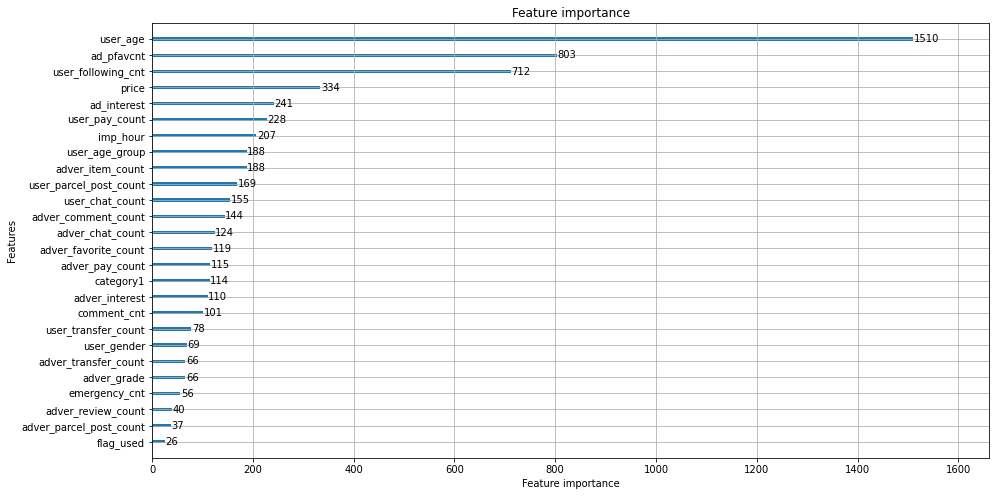

In [ ]:
# 특성 중요도를 시각화
fig, ax = plt.subplots(figsize = (15, 8))
plot_importance(model, ax=ax)
plt.show()

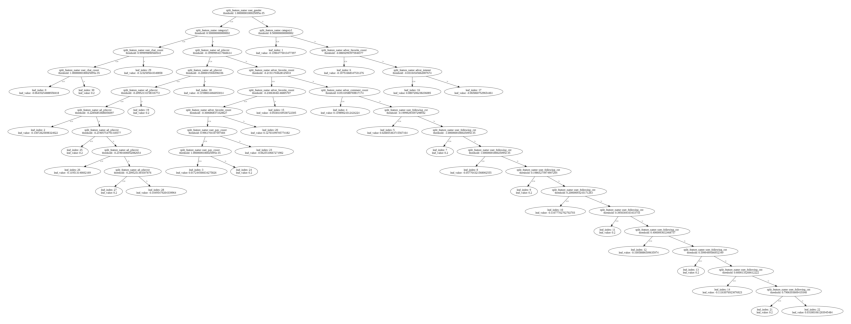

In [ ]:
# decision tree를 시각화. 
fig, ax = plt.subplots(figsize = (15, 10))
plot_tree(model, ax=ax)

In [ ]:
# 가장 좋은 성능을 보인 파라미터 조합의 estimator을 model에 저장
model = gs.best_estimator_

# dataset 데이터를 예측 및 성능 평가
data_pred = model.predict(X_test)

print(f'optimized parameters: {model}')
print('test score : {:.3f}'.format(model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, data_pred))
print(confusion_matrix(y_test, data_pred))

optimized parameters: LGBMClassifier(max_depth=50, n_estimators=200, random_state=2022)
test score : 0.964
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    245325
           1       0.14      0.04      0.07      7414

    accuracy                           0.96    252739
   macro avg       0.56      0.52      0.52    252739
weighted avg       0.95      0.96      0.95    252739

[[243428   1897]
 [  7097    317]]


# 최적의 하이퍼파라미터로 재 모델링

In [ ]:
file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)

In [ ]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }

def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
data = reorganization(df)

In [ ]:
def preprocessing(df):
    # 데이터 유형별 분류하기
    modified_df = pd.DataFrame()

    for i, c in enumerate(df.columns): 
        if (c in cols['obj']) | (c in cols['cat']): 
          if 'click' in c:    # click_label 컬럼 = y 변수로 사용 (그대로 두기)
                modified_df = pd.concat([modified_df, df[c]], axis=1)
          else:
            dummied_data = LabelEncoder().fit_transform(df[[c]])
            dummied_data = pd.DataFrame(dummied_data, columns = [c])
            modified_df = pd.concat([modified_df, dummied_data], axis=1)

        else:
            scaled_num_data = RobustScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)

    print('---- Data info ----')
    print(f'Modified DF columns: {modified_df.columns.to_list()}')
    print(f'# of Modified DF columns: {modified_df.shape[1]}')
    print(f'DataFrame has no null?', end = ' ')
    if df.isnull().sum().count() == df.shape[1]:
      print('Yes')
    else:
      print('No')
    return modified_df

In [ ]:
df = preprocessing(data)
df.head(3)

---- Data info ----
Modified DF columns: ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']
# of Modified DF columns: 27
DataFrame has no null? Yes


,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,0,0,0,0,0,10,0,-0.904762,0.4,0.0,0.0,0.0,2.0,0.442373,0.0,-0.138204,-0.190476,0.541252,0.731446,0.742301,-0.030500,0.695833,0.246594,1.209776,0.0,0.714286,17.769231
1,0,0,0,1,1,10,0,-0.428571,-0.2,0.0,0.0,0.0,0.0,-0.311864,3.0,0.607335,1.228571,-0.086978,0.442728,0.173420,0.339880,0.438889,0.053134,1.749491,0.0,8.142857,0.461538
2,0,0,0,4,1,11,0,0.857143,-0.2,0.0,0.0,0.0,0.0,-0.496610,12.0,4.085811,7.000000,0.569583,0.118404,2.799028,0.783118,0.134722,0.313351,0.169043,0.0,2.285714,-0.153846


In [ ]:
X = df[df.columns.difference(['click_label'])]
y = df['click_label']

print(f"X features' name (10): {X.columns.to_list()[:10]}")
print(f"y feature's name: {y.name}")
print()

## create train and test datasets (7:3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기

print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
print()
print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("data's shape (x -> y & train -> test): ", (X_train.shape, y_train.shape, X_test.shape, y_train.shape))
print()

## create train and validation datasets (8:2 ratio)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022)

print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
print()
print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
print("data's shape (x -> y & train -> test): ", (x_train.shape, y_train.shape, x_val.shape, y_val.shape))
print()

X features' name (10): ['ad_interest', 'ad_pfavcnt', 'adver_chat_count', 'adver_comment_count', 'adver_favorite_count', 'adver_grade', 'adver_interest', 'adver_item_count', 'adver_parcel_post_count', 'adver_pay_count']
y feature's name: click_label

# of train_data's rows: 589724 
# of test_data's rows: 252739

train:test ratio = 0.7:0.3
data's shape (x -> y & train -> test):  ((1144850, 26), (1144850,), (252739, 26), (1144850,))

# of train_data's rows: 915880 
# of validation_data's rows: 228970

train:test ratio = 0.8:0.2
data's shape (x -> y & train -> test):  ((915880, 26), (915880,), (228970, 26), (228970,))



In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200, learning_rate=0.001, max_depth=50)
lgb_model = lgb_model.fit(x_train, y_train)
lgb_model

LGBMClassifier(learning_rate=0.001, max_depth=50, n_estimators=200,
               random_state=2022)

In [ ]:
# 모델 성능을 출력해보자.
print('train score : {:.3f}'.format(lgb_model.score(x_train, y_train)))
print('validation score : {:.3f}'.format(lgb_model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, lgb_model.predict(x_val)))
print(confusion_matrix(y_val, lgb_model.predict(x_val)))

train score : 0.743
validation score : 0.744
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75    114845
           1       0.75      0.73      0.74    114125

    accuracy                           0.74    228970
   macro avg       0.74      0.74      0.74    228970
weighted avg       0.74      0.74      0.74    228970

[[87191 27654]
 [30943 83182]]


In [ ]:
lgb_model.predict_proba(x_val)

array([[0.54836972, 0.45163028],
       [0.52590206, 0.47409794],
       [0.46844729, 0.53155271],
       ...,
       [0.44671089, 0.55328911],
       [0.51288676, 0.48711324],
       [0.52763451, 0.47236549]])

In [ ]:
# dataset 데이터를 예측 및 성능 평가
data_pred = lgb_model.predict(x_val)

In [ ]:
print('validation score : {:.3f}'.format(lgb_model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, data_pred))
print(confusion_matrix(y_val, data_pred))

validation score : 0.744
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75    114845
           1       0.75      0.73      0.74    114125

    accuracy                           0.74    228970
   macro avg       0.74      0.74      0.74    228970
weighted avg       0.74      0.74      0.74    228970

[[87191 27654]
 [30943 83182]]


In [ ]:
lgb_model.predict_proba(x_val)

array([[0.54836972, 0.45163028],
       [0.52590206, 0.47409794],
       [0.46844729, 0.53155271],
       ...,
       [0.44671089, 0.55328911],
       [0.51288676, 0.48711324],
       [0.52763451, 0.47236549]])

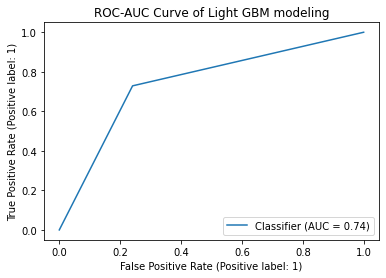

In [ ]:
RocCurveDisplay.from_predictions(y_val, data_pred)
plt.title('ROC-AUC Curve of Light GBM modeling')
plt.show()

In [ ]:
# dataset 데이터를 예측 및 성능 평가
data_pred = lgb_model.predict(X_test)

print('test score : {:.3f}'.format(lgb_model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, data_pred))
print(confusion_matrix(y_test, data_pred))

test score : 0.749
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.85    245325
           1       0.05      0.45      0.10      7414

    accuracy                           0.75    252739
   macro avg       0.52      0.61      0.47    252739
weighted avg       0.95      0.75      0.83    252739

[[185837  59488]
 [  4043   3371]]


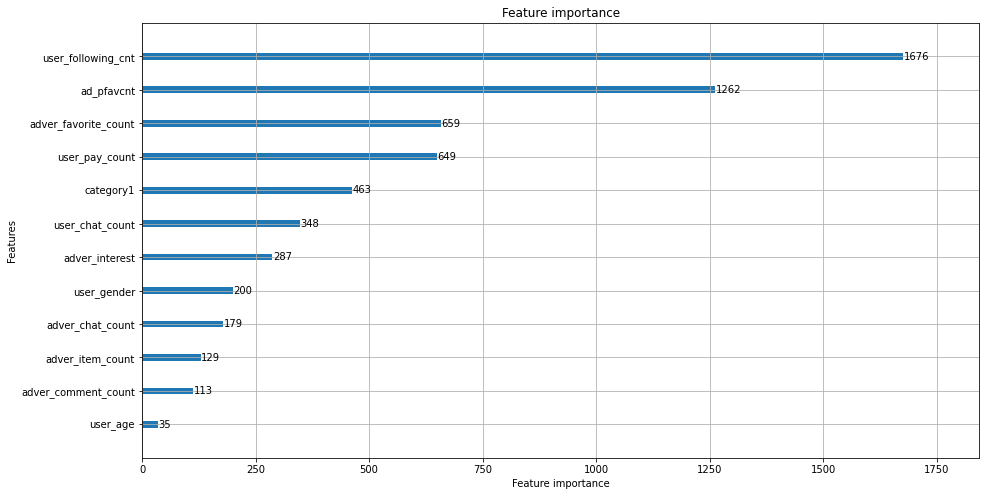

In [ ]:
# 특성 중요도를 시각화
fig, ax = plt.subplots(figsize = (15, 8))
plot_importance(lgb_model, ax=ax)
plt.show()

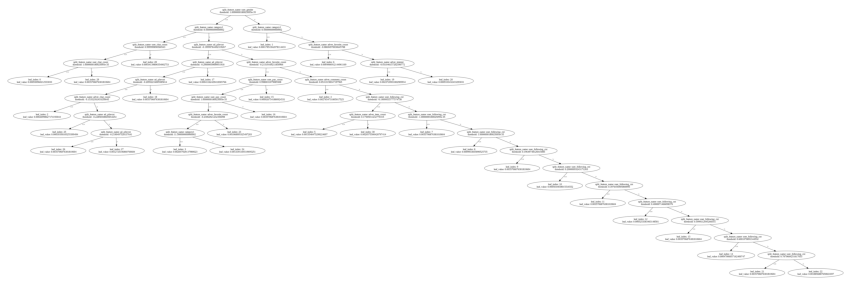

In [ ]:
# decision tree를 시각화. 
fig, ax = plt.subplots(figsize = (15, 10))
plot_tree(lgb_model, ax=ax)

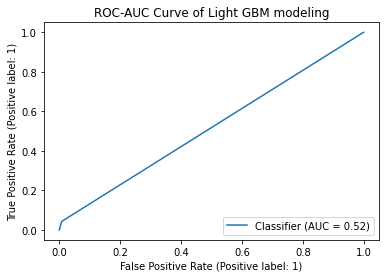

In [ ]:
RocCurveDisplay.from_predictions(y_test, data_pred)
plt.title('ROC-AUC Curve of Light GBM modeling')
plt.show()

# SMOTE 제거 후 모델링

In [ ]:
file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)

In [ ]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }

def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
data = reorganization(df)

In [ ]:
def preprocessing(df):
    # 데이터 유형별 분류하기
    modified_df = pd.DataFrame()

    for i, c in enumerate(df.columns): 
        if (c in cols['obj']) | (c in cols['cat']): 
          if 'click' in c:    # click_label 컬럼 = y 변수로 사용 (그대로 두기)
                modified_df = pd.concat([modified_df, df[c]], axis=1)
          else:
            dummied_data = LabelEncoder().fit_transform(df[[c]])
            dummied_data = pd.DataFrame(dummied_data, columns = [c])
            modified_df = pd.concat([modified_df, dummied_data], axis=1)

        else:
            scaled_num_data = RobustScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)

    print('---- Data info ----')
    print(f'Modified DF columns: {modified_df.columns.to_list()}')
    print(f'# of Modified DF columns: {modified_df.shape[1]}')
    print(f'DataFrame has no null?', end = ' ')
    if df.isnull().sum().count() == df.shape[1]:
      print('Yes')
    else:
      print('No')
    return modified_df

In [ ]:
df = preprocessing(data)
df.head(3)

---- Data info ----
Modified DF columns: ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']
# of Modified DF columns: 27
DataFrame has no null? Yes


,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,0,0,0,0,0,10,0,-0.904762,0.4,0.0,0.0,0.0,2.0,0.442373,0.0,-0.138204,-0.190476,0.541252,0.731446,0.742301,-0.030500,0.695833,0.246594,1.209776,0.0,0.714286,17.769231
1,0,0,0,1,1,10,0,-0.428571,-0.2,0.0,0.0,0.0,0.0,-0.311864,3.0,0.607335,1.228571,-0.086978,0.442728,0.173420,0.339880,0.438889,0.053134,1.749491,0.0,8.142857,0.461538
2,0,0,0,4,1,11,0,0.857143,-0.2,0.0,0.0,0.0,0.0,-0.496610,12.0,4.085811,7.000000,0.569583,0.118404,2.799028,0.783118,0.134722,0.313351,0.169043,0.0,2.285714,-0.153846


In [ ]:
X = df[df.columns.difference(['click_label'])]
y = df['click_label']

print(f"X features' name (10): {X.columns.to_list()[:10]}")
print(f"y feature's name: {y.name}")
print()

## create train and test datasets (7:3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기

print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
print()
print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

print("data's shape (x -> y & train -> test): ", (X_train.shape, y_train.shape, X_test.shape, y_train.shape))
print()

## create train and validation datasets (8:2 ratio)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022)

print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
print()
print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
print("data's shape (x -> y & train -> test): ", (x_train.shape, y_train.shape, x_val.shape, y_val.shape))
print()

X features' name (10): ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count']
y feature's name: click_label

# of train_data's rows: 589724 
# of test_data's rows: 252739

train:test ratio = 0.7:0.3
data's shape (x -> y & train -> test):  ((589724, 27), (589724,), (252739, 27), (589724,))

# of train_data's rows: 471779 
# of validation_data's rows: 117945

train:test ratio = 0.8:0.2
data's shape (x -> y & train -> test):  ((471779, 27), (471779,), (117945, 27), (117945,))



In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200, learning_rate=0.001, max_depth=50)
lgb_model = lgb_model.fit(x_train, y_train)

In [ ]:
# 모델 성능을 출력해보자.
print('train score : {:.3f}'.format(lgb_model.score(x_train, y_train)))
print('validation score : {:.3f}'.format(lgb_model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, lgb_model.predict(x_val)))
print(confusion_matrix(y_val, lgb_model.predict(x_val)))

train score : 0.971
validation score : 0.970
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    114424
           1       0.00      0.00      0.00      3521

    accuracy                           0.97    117945
   macro avg       0.49      0.50      0.49    117945
weighted avg       0.94      0.97      0.96    117945

[[114424      0]
 [  3521      0]]


In [ ]:
lgb_model.predict_proba(x_val)

array([[0.97608956, 0.02391044],
       [0.97608956, 0.02391044],
       [0.97608956, 0.02391044],
       ...,
       [0.97608956, 0.02391044],
       [0.97608956, 0.02391044],
       [0.97608956, 0.02391044]])

In [ ]:
# dataset 데이터를 예측 및 성능 평가
data_pred = lgb_model.predict(X_test)

print(f'optimized parameters: {lgb_model}')
print('test score : {:.3f}'.format(lgb_model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, data_pred))
print(confusion_matrix(y_test, data_pred))

optimized parameters: LGBMClassifier(learning_rate=0.001, max_depth=50, n_estimators=200,
               random_state=2022)
test score : 0.749
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.85    245325
           1       0.05      0.45      0.10      7414

    accuracy                           0.75    252739
   macro avg       0.52      0.61      0.47    252739
weighted avg       0.95      0.75      0.83    252739

[[185837  59488]
 [  4043   3371]]


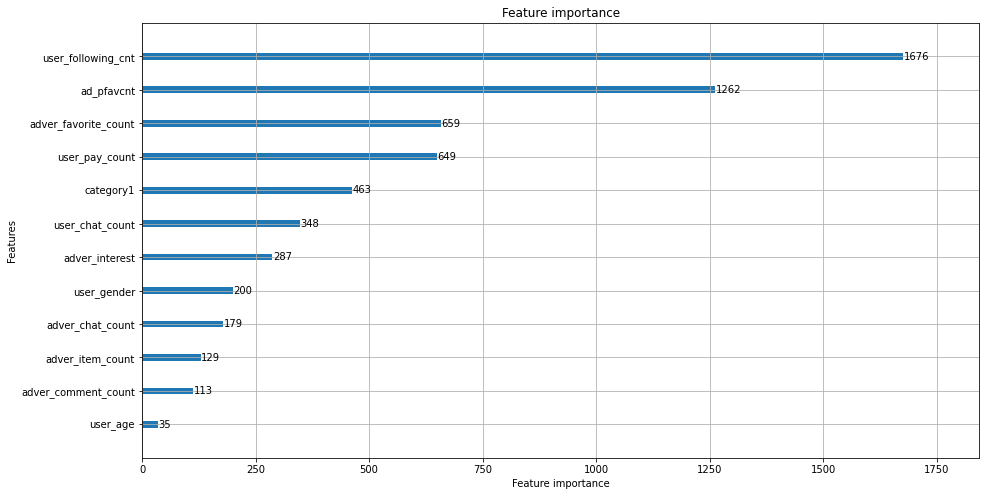

In [ ]:
# 특성 중요도를 시각화
fig, ax = plt.subplots(figsize = (15, 8))
plot_importance(lgb_model, ax=ax)
plt.show()

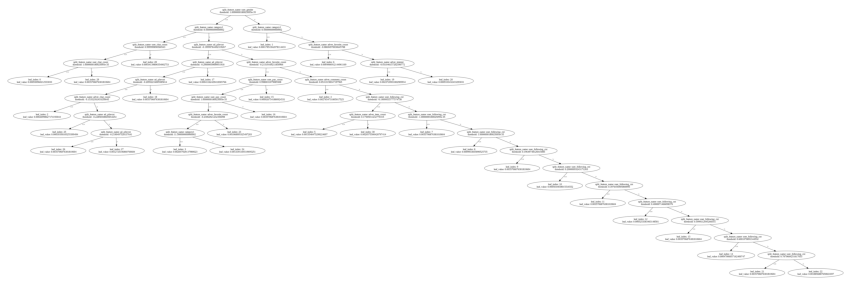

In [ ]:
# decision tree를 시각화. 
fig, ax = plt.subplots(figsize = (15, 10))
plot_tree(lgb_model, ax=ax)

In [ ]:
roc_auc_score(y_test, data_pred)

0.6060969184994904

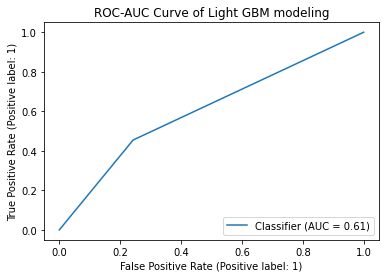

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, data_pred)
plt.title('ROC-AUC Curve of Light GBM modeling')
plt.show()

조건: 

1. 검증 데이터 분리 안함
- 불균형 처리 유무

2. 검증 데이터 분리 함
- 불균형 처리 유무

In [ ]:
file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842463 entries, 0 to 842462
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   imp_id                   842463 non-null  object 
 1   content_id               842463 non-null  int64  
 2   server_time_kst_x        842463 non-null  object 
 3   imp_hour                 842463 non-null  int64  
 4   bid_price_x              842463 non-null  int64  
 5   click_label              842463 non-null  int64  
 6   user_gender              842463 non-null  object 
 7   user_age_group           842463 non-null  int64  
 8   user_age                 842463 non-null  int64  
 9   user_following_cnt       842463 non-null  int64  
 10  user_pay_count           842463 non-null  int64  
 11  user_parcel_post_count   842463 non-null  int64  
 12  user_transfer_count      842463 non-null  int64  
 13  user_chat_count          842463 non-null  int64  
 14  name

In [ ]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }

def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
data = reorganization(df)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842463 entries, 0 to 842462
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_gender              842463 non-null  object 
 1   imp_hour                 842463 non-null  int64  
 2   click_label              842463 non-null  int64  
 3   user_age_group           842463 non-null  int64  
 4   flag_used                842463 non-null  float64
 5   category1                842463 non-null  int64  
 6   emergency_cnt            842463 non-null  float64
 7   user_age                 842463 non-null  int64  
 8   user_following_cnt       842463 non-null  int64  
 9   user_pay_count           842463 non-null  int64  
 10  user_parcel_post_count   842463 non-null  int64  
 11  user_transfer_count      842463 non-null  int64  
 12  user_chat_count          842463 non-null  int64  
 13  price                    842463 non-null  float64
 14  comm

In [ ]:
def preprocessing(df):
    # 데이터 유형별 분류하기
    modified_df = pd.DataFrame()

    for i, c in enumerate(df.columns): 
        if (c in cols['obj']) | (c in cols['cat']): 
          if 'click' in c:    # click_label 컬럼 = y 변수로 사용 (그대로 두기)
                modified_df = pd.concat([modified_df, df[c]], axis=1)
          else:
            dummied_data = LabelEncoder().fit_transform(df[[c]])
            dummied_data = pd.DataFrame(dummied_data, columns = [c])
            modified_df = pd.concat([modified_df, dummied_data], axis=1)

        else:
            scaled_num_data = RobustScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)

    print('---- Data info ----')
    print(f'Modified DF columns: {modified_df.columns.to_list()}')
    print(f'# of Modified DF columns: {modified_df.shape[1]}')
    print(f'DataFrame has no null?', end = ' ')
    if df.isnull().sum().count() == df.shape[1]:
      print('Yes')
    else:
      print('No')
    return modified_df

In [ ]:
df = preprocessing(data)
df.head(3)

---- Data info ----
Modified DF columns: ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']
# of Modified DF columns: 27
DataFrame has no null? Yes


,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,0,0,0,0,0,10,0,-0.904762,0.4,0.0,0.0,0.0,2.0,0.442373,0.0,-0.138204,-0.190476,0.541252,0.731446,0.742301,-0.030500,0.695833,0.246594,1.209776,0.0,0.714286,17.769231
1,0,0,0,1,1,10,0,-0.428571,-0.2,0.0,0.0,0.0,0.0,-0.311864,3.0,0.607335,1.228571,-0.086978,0.442728,0.173420,0.339880,0.438889,0.053134,1.749491,0.0,8.142857,0.461538
2,0,0,0,4,1,11,0,0.857143,-0.2,0.0,0.0,0.0,0.0,-0.496610,12.0,4.085811,7.000000,0.569583,0.118404,2.799028,0.783118,0.134722,0.313351,0.169043,0.0,2.285714,-0.153846


In [ ]:
X = df[df.columns.difference(['click_label'])]
y = df['click_label']

print(f"X features' name (10): {X.columns.to_list()[:10]}")
print(f"y feature's name: {y.name}")
print()

## create train and test datasets (7:3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기

print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
print("data's shape (x -> y & train -> test): ", (X_train.shape, y_train.shape, X_test.shape, y_train.shape))
print()

## create train and validation datasets (8:2 ratio)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)

print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
print()
print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
print("data's shape (x -> y & train -> test): ", (x_train.shape, y_train.shape, x_val.shape, y_train.shape))
print()

X features' name (10): ['ad_interest', 'ad_pfavcnt', 'adver_chat_count', 'adver_comment_count', 'adver_favorite_count', 'adver_grade', 'adver_interest', 'adver_item_count', 'adver_parcel_post_count', 'adver_pay_count']
y feature's name: click_label

train:test ratio = 0.7:0.3
# of train_data's rows: 1144850 
# of test_data's rows: 252739
data's shape (x -> y & train -> test):  ((1144850, 26), (1144850,), (252739, 26), (1144850,))

# of train_data's rows: 915880 
# of validation_data's rows: 228970

train:test ratio = 0.8:0.2
data's shape (x -> y & train -> test):  ((915880, 26), (915880,), (228970, 26), (915880,))



In [ ]:
model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200, learning_rate=0.001, max_depth=50)
model = model.fit(x_train, y_train)

# 모델 성능을 출력해보자.
print('train score : {:.3f}'.format(model.score(x_train, y_train)))
print('test score : {:.3f}'.format(model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, model.predict(X_test)))
print(confusion_matrix(y_test, model.predict(X_test)))

train score : 0.740
test score : 0.739
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85    245325
           1       0.05      0.46      0.09      7414

    accuracy                           0.74    252739
   macro avg       0.52      0.60      0.47    252739
weighted avg       0.95      0.74      0.83    252739

[[183420  61905]
 [  3989   3425]]


In [ ]:
print('validation score : {:.3f}'.format(model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, model.predict(x_val)))
print(confusion_matrix(y_val, model.predict(x_val)))

validation score : 0.739
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74    114485
           1       0.74      0.73      0.74    114485

    accuracy                           0.74    228970
   macro avg       0.74      0.74      0.74    228970
weighted avg       0.74      0.74      0.74    228970

[[85604 28881]
 [30772 83713]]


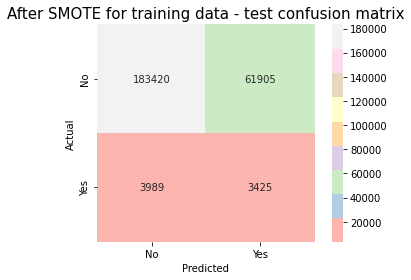

In [ ]:
import seaborn as sns
LABELS = ['No', 'Yes']
cm = confusion_matrix(y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt = 'g', cmap='Pastel1', square=True, xticklabels=LABELS, yticklabels=LABELS)
plt.title('After SMOTE for training data - test confusion matrix', fontsize=15)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.tight_layout()
plt.show()

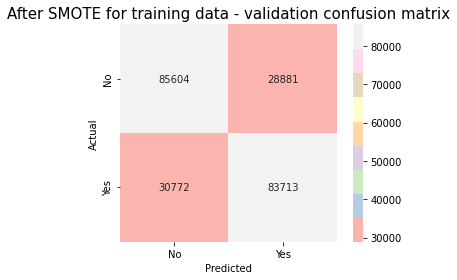

In [ ]:
LABELS = ['No', 'Yes']
cm = confusion_matrix(y_val, model.predict(x_val))
sns.heatmap(cm, annot=True, fmt = 'g', cmap='Pastel1', square=True, xticklabels=LABELS, yticklabels=LABELS)
plt.title('After SMOTE for training data - validation confusion matrix', fontsize=15)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.tight_layout()
plt.show()

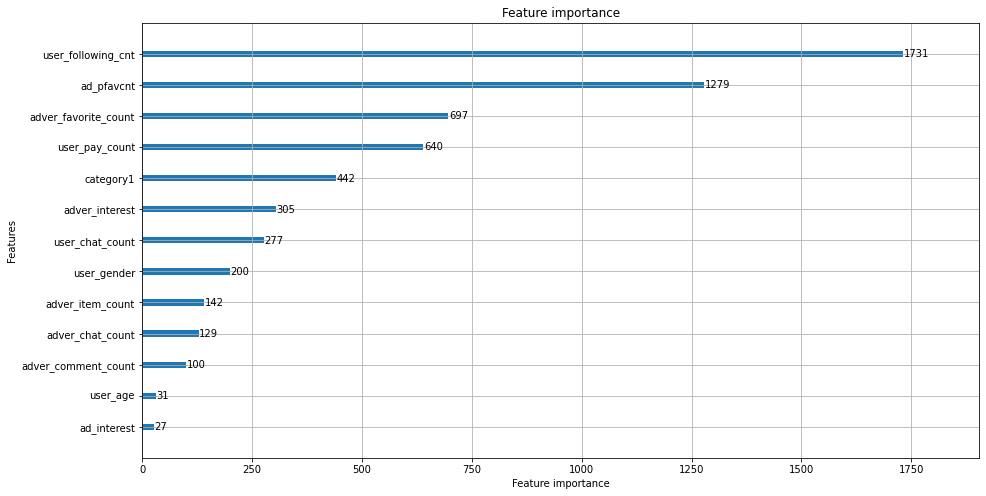

In [ ]:
# 특성 중요도를 시각화
fig, ax = plt.subplots(figsize = (15, 8))
plot_importance(model, ax=ax)
plt.show()

In [ ]:
print(f'ROC-AUC score: {roc_auc_score(y_val, model.predict(x_val))}')

ROC-AUC score: 0.7394724199676813


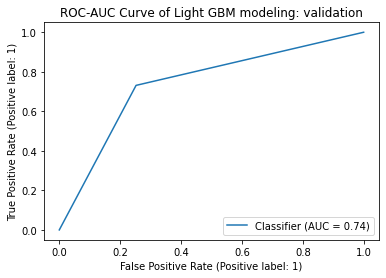

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_val, model.predict(x_val))
plt.title('ROC-AUC Curve of Light GBM modeling: validation')
plt.show()

ROC-AUC score: 0.6048125589197795


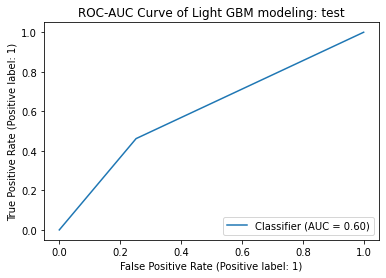

In [ ]:
print(f'ROC-AUC score: {roc_auc_score(y_test, model.predict(X_test))}')
RocCurveDisplay.from_predictions(y_test, model.predict(X_test))
plt.title('ROC-AUC Curve of Light GBM modeling: test')
plt.show()

In [ ]:
print(f'ACC score: {accuracy_score(y_train, model.predict(x_train))}')

ACC score: 0.7397038913394768


In [ ]:
print(f'ROC-AUC score: {roc_auc_score(y_train, model.predict(x_train))}')
print('Light GBM 분류 report:\n', classification_report(y_train, model.predict(x_train)))

ROC-AUC score: 0.7397038913394768
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74    457940
           1       0.74      0.73      0.74    457940

    accuracy                           0.74    915880
   macro avg       0.74      0.74      0.74    915880
weighted avg       0.74      0.74      0.74    915880



[0.85526215 0.04751779]
원본 데이터 형태: (915880, 26)
축소된 데이터 형태: (915880, 2)
                 1           2
0       -41.522548  113.861501
1       -41.904674   -3.747705
2       -41.978787    1.548905
3       -41.972328   -3.845676
4       -41.930861   -3.755364
...            ...         ...
915875  -33.927790   -2.330389
915876  212.927966   -3.990216
915877  -41.909757   -3.302981
915878  -32.953625   -3.790988
915879  -41.936465   -3.643642

[915880 rows x 2 columns]



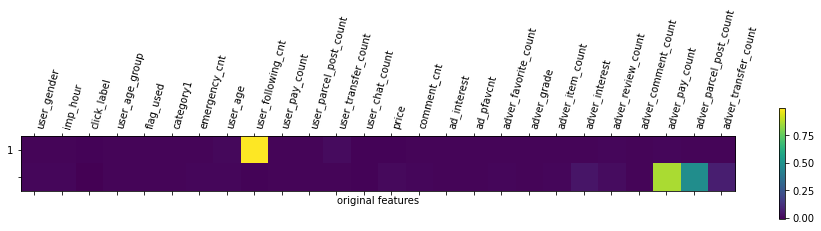


[0.85526215 0.04751779 0.03160584]
원본 데이터 형태: (915880, 26)
축소된 데이터 형태: (915880, 3)
                 1           2          3
0       -41.522548  113.861501 -23.362506
1       -41.904674   -3.747705  -1.701431
2       -41.978787    1.548905   4.839497
3       -41.972328   -3.845676  -1.605924
4       -41.930861   -3.755364  -1.994685
...            ...         ...        ...
915875  -33.927790   -2.330389   0.510156
915876  212.927966   -3.990216   7.238145
915877  -41.909757   -3.302981  -1.175985
915878  -32.953625   -3.790988  -0.502093
915879  -41.936465   -3.643642  -1.736563

[915880 rows x 3 columns]



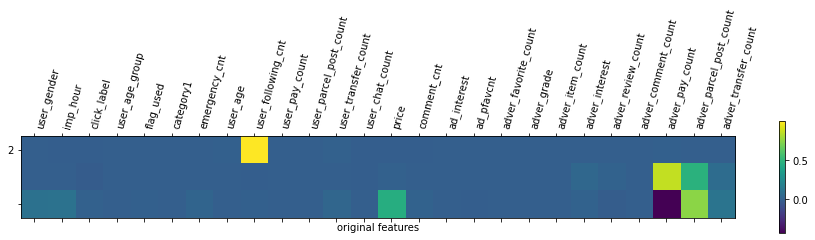


[0.85526215 0.04751779 0.03160584 0.03000254]
원본 데이터 형태: (915880, 26)
축소된 데이터 형태: (915880, 4)
                 1           2          3         4
0       -41.522548  113.861501 -23.362506 -6.807713
1       -41.904674   -3.747705  -1.701431  3.262149
2       -41.978787    1.548905   4.839497  6.925051
3       -41.972328   -3.845676  -1.605924  3.225628
4       -41.930861   -3.755364  -1.994685  3.735515
...            ...         ...        ...       ...
915875  -33.927790   -2.330389   0.510156  4.742316
915876  212.927966   -3.990216   7.238145 -9.316484
915877  -41.909757   -3.302981  -1.175985  4.080275
915878  -32.953625   -3.790988  -0.502093  1.202220
915879  -41.936465   -3.643642  -1.736563  3.593940

[915880 rows x 4 columns]



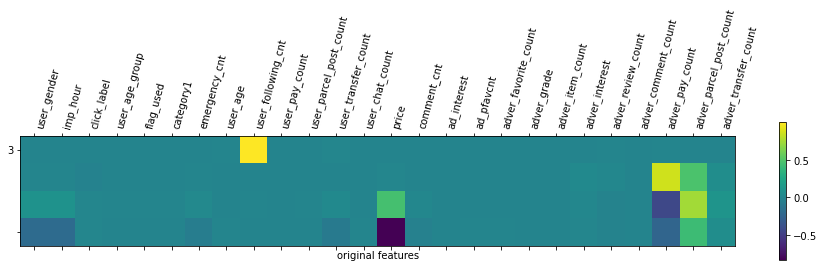


[0.85526215 0.04751779 0.03160584 0.03000254 0.01702505]
원본 데이터 형태: (915880, 26)
축소된 데이터 형태: (915880, 5)
                 1           2          3         4         5
0       -41.522548  113.861501 -23.362506 -6.807713 -0.791582
1       -41.904674   -3.747705  -1.701431  3.262149 -6.456103
2       -41.978787    1.548905   4.839497  6.925051 -2.376807
3       -41.972328   -3.845676  -1.605924  3.225628 -2.346090
4       -41.930861   -3.755364  -1.994685  3.735515 -8.020416
...            ...         ...        ...       ...       ...
915875  -33.927790   -2.330389   0.510156  4.742316 -6.602065
915876  212.927966   -3.990216   7.238145 -9.316484 -0.906332
915877  -41.909757   -3.302981  -1.175985  4.080275 -6.756447
915878  -32.953625   -3.790988  -0.502093  1.202220 -7.478979
915879  -41.936465   -3.643642  -1.736563  3.593940 -7.984540

[915880 rows x 5 columns]



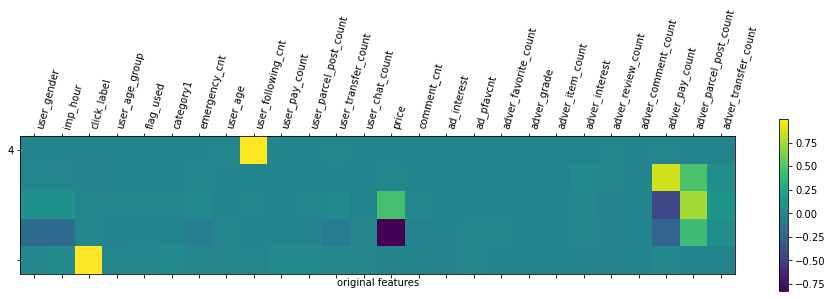

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

for i in range(2, 6):
  pca = PCA(n_components = i) #주성분 개수 = 2개

  # pca model 학습 : X_data만 필요
  pca.fit(X_test)

  # explained_variance_ratio_ 속성은 전체 변동성에서 개별 principal component별로 차지하는 변동성 비율을 제공한다
  print(pca.explained_variance_ratio_)

  # 학습된 pca model을 이용해 data 변환 : 차원 축소
  data_pca = pca.transform(x_train)
  print("원본 데이터 형태:", str(x_train.shape))
  print("축소된 데이터 형태:", str(data_pca.shape))

  result = pd.DataFrame(data_pca)
  result.rename(columns={i:(j+1) for i, j in zip(result.columns, range(i))}, inplace=True)
  print(result)

  # 시각화로 확인해보자. (차원축소 시 중요한 영향을 끼친 컬럼들 확인)
  plt.matshow(pca.components_) #heatmap
  print()

  plt.xticks(range(len(df.columns)-1), df.columns, rotation=75, ha= 'left')
  comp = [j for j in range(i)]
  for n in comp:
    plt.yticks([0, i-1], [n])

  plt.xlabel("original features")

  plt.colorbar()

  plt.show()
  print()

In [ ]:
result.shape

(915880, 5)